<a href="https://en.wikipedia.org/wiki/Auk%C5%A1taitija" target="_blank"><img src="https://upload.wikimedia.org/wikipedia/lt/1/18/Aukstaitijosherbas.PNG" alt="IMAGE ALT TEXT HERE" width="480" border="10"/></a>

--------------------
austechia is a Jupyter notebook that provides some example code of how to plot trees imported with baltic.

------------

Copyright 2016 [Gytis Dudas](https://twitter.com/evogytis). Licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

In [1]:
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')

## The classes of baltic
------------

There are 3 main classes in baltic:
- node = internal branches
- leaf = external branches
- tree = the entirety of the tree

The node and leaf classes are similar and share many parameters in common, such as branch length, height, position in absolute time, traits, parents, x and y coordinates and index of the character which defined them in the tree string. They differ in that the node class contains a list of its children objects for tree traversals, called children and a list of all tips that descend from it eventually, called leaves. Node class also contains parameters like childHeight and numChildren which are less important. The leaf class contains two name variables: numName and name. numName corresponds to whatever was used to designate the tip in the tree string. name can be set later and is meant to handle scenarios where the tree string contains tip names encoded as numbers (Nexus format), which can be decoded into name, rather than overwriting whatever was caught in numName.

The tree class wraps leaf and node classes together by performing operations to build, manipulate, visualise and analyse the full tree data structure. The recommended way of interacting with the tree is via the Objects list, which is a flat list of all branches in the tree.

baltic now also has a clade class. They are introduced when a subtree is collapsed and pose as tips for tree traversals.

## The function
------------

At the top is the make_tree function. Given a valid tree string it will transform the information contained in the tree string into an actual tree data structure. If there are elements within the tree string that it can't parse it will warn the user of this. The most common reasons for this are unexpected characters in branch labels or something unexpected in tip names (particularly illegal characters: whitespace, parentheses, commas, semicolons, etc).

In [2]:
treestring="(('taxon_A'[&comment=\"stuff\"]:1.0,'taxon_B':1.0)[&comment_too=\"stuff_too\"]:1.0,'taxon_C':2.0);"
bt_tree_object=bt.make_tree(treestring,verbose=True)
bt_tree_object.traverse_tree() ## required to set heights
bt_tree_object.treeStats() ## report stats about tree
bt_tree_object.setAbsoluteTime(2018.0) ## set absolute time of all branches by specifying date of most recent tip

for k in bt_tree_object.Objects: ## iterate over a flat list of branches
    print 'branch unique id: %s branch height: %.2f decimal date: %s'%(k.index,k.height,k.absoluteTime)
    
    if len(k.traits)>0: ## branch has comments
        print 'branch has annotations: %s'%(', '.join(['(key: %s value: %s)'%(key,k.traits[key]) for key in k.traits]))
    
    if k.branchType=='node': ## if branch is internal
        print 'branch is internal, with %s children and is the ancestor to %s'%(len(k.children),', '.join(k.leaves))
    
    elif k.branchType=='leaf': ## otherwise if branch is external
        print 'branch is external, named %s in tree string (converted name: %s)'%(k.numName,k.name)

0 adding node
1 adding node
2 adding leaf (non-BEAST) taxon_A
11 comment: &comment="stuff"
adding branch length (29) 1.000000
34 adding leaf (non-BEAST) taxon_B
adding branch length (43) 1.000000
48 comment: &comment_too="stuff_too"
adding branch length (74) 1.000000
79 adding leaf (non-BEAST) taxon_C
adding branch length (88) 2.000000

Tree height: 2.000000
Tree length: 5.000000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5 (2 nodes and 3 leaves)

branch unique id: 0 branch height: 0.00 decimal date: 2016.0
branch is internal, with 2 children and is the ancestor to taxon_B, taxon_C, taxon_A
branch unique id: 1 branch height: 1.00 decimal date: 2017.0
branch has annotations: (key: comment_too value: stuff_too)
branch is internal, with 2 children and is the ancestor to taxon_B, taxon_A
branch unique id: 2 branch height: 2.00 decimal date: 2018.0
branch has annotations: (key: comment value: stuff)
branch is external, named taxon_A in tree string (converted 

## Tree import
-----------
baltic was primarily written to handle FigTree files with rich branch annotations. These nexus files can be loaded via the ``loadNexus()`` function, or if you have a newick tree you can use ``loadNewick``. ``loadNexus`` accepts regular expression to find dates for tips if they are encoded in the names, find tree strings (if using nexus files not generated in BEAST).

In [3]:
from IPython.display import HTML
import re
import copy

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

import numpy as np
from scipy.special import binom
import bezier
import itertools
import requests
from StringIO import StringIO
from Bio import Phylo
from cStringIO import StringIO as cStringIO

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate

address='https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%20trees/InfB_NPt_ALLs1.mcc.tre' ## address of example tree
fetch_tree = requests.get(address) ## fetch tree
treeFile=StringIO(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file
ll.treeStats() ## report stats about tree

path='<iframe style="border: 0; width: 400px; height: 345px;" src="https://bandcamp.com/EmbeddedPlayer/album=2074815275/size=large/bgcol=ffffff/linkcol=333333/artwork=small/track=42188979/transparent=true/" seamless><a href="http://obsrr.bandcamp.com/album/nustebusiam-neb-ti">NUSTEBUSIAM NEBUTI by OBSRR</a></iframe>'

print 'Done!'
HTML(path)


Tree height: 29.430115
Tree length: 451.887106
strictly bifurcating tree
annotations present

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Done!


## Plotting trees
-----------
As long as the drawTree() function has been called from the tree object it's possible to draw out the tree by iterating over every branch in the tree object and plotting it. It remains up to the user as to how the tree gets plotted in terms of colour, branch width, tip sizes, tip labels, etc.

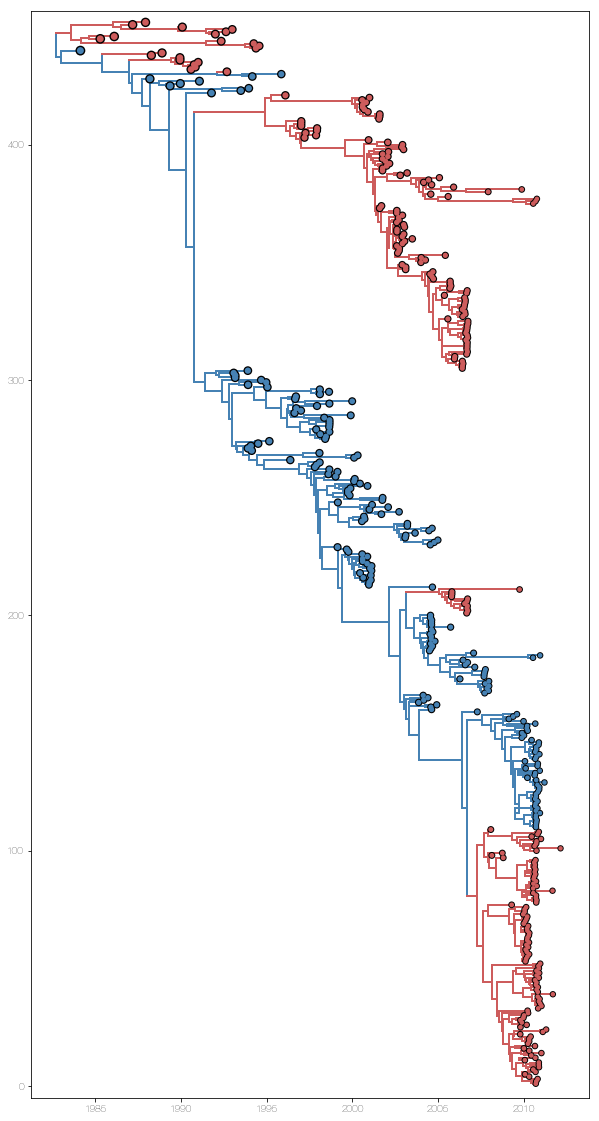

In [4]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
c_func=lambda k: 'indianred' if k.traits['PB1']=='V' else 'steelblue' ## colour of branches
s_func=lambda k: 50-30*k.height/ll.treeHeight ## size of tips
z_func=lambda k: 100

cu_func=lambda k: 'k' ## for plotting a black outline of tip circles
su_func=lambda k: 2*(50-30*k.height/ll.treeHeight) ## black outline in twice as big as tip circle 
zu_func=lambda k: 99
ll.plotTree(ax,x_attr=x_attr,colour_function=c_func) ## plot branches
ll.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=c_func,zorder_function=z_func) ## plot circles at tips
ll.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## plot circles under tips (to give an outline)

ax.set_ylim(-5,ll.ySpan+5)
plt.show()

## Collapsing branches
------
Branches can be collapsed based on trait values or attribute values that don't satisfy a function. The returned tree object then needs to be redrawn using the drawTree() method to get new y positions for branches.

903 644


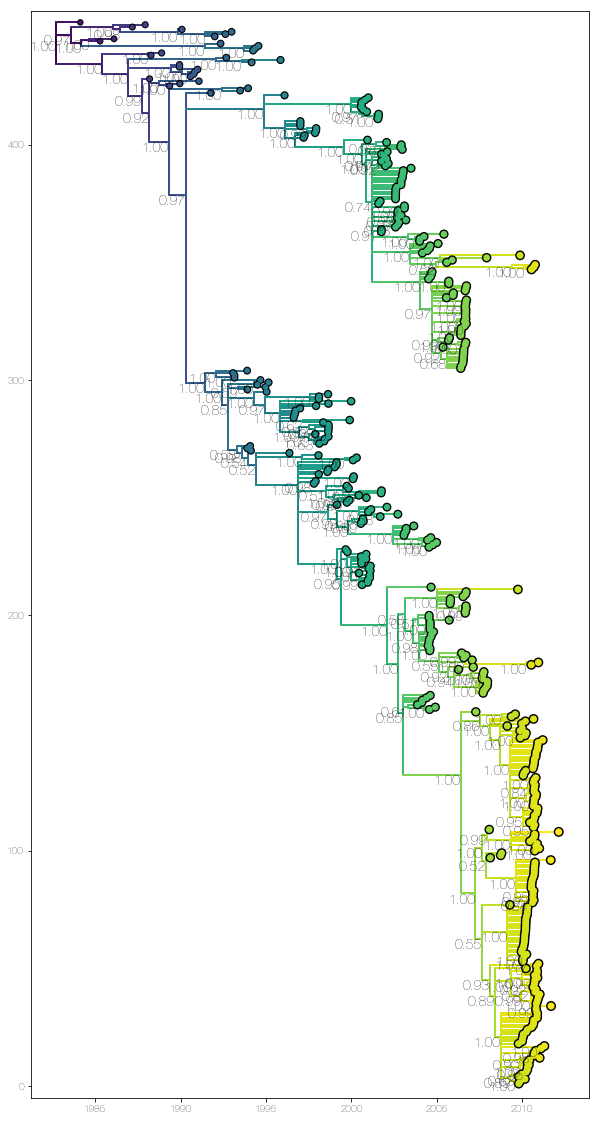

In [5]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

cmap=mpl.cm.viridis

cc=ll.collapseBranches(lambda k: k.traits['posterior'] <= 0.5) ## collapse branches below 0.5 posterior probability
# cc=ll.collapseBranches(lambda k: k.index>1000000) ## collapse branches whose index in tree string are above 1 million
cc.sortBranches() ## sort branches, also redraws tree

print len(ll.Objects),len(cc.Objects) ## check how many branches were collapsed

x_attr=lambda k: k.absoluteTime
c_func=lambda k: cmap(k.height/ll.treeHeight) ## colour gets determined by height of branch
s_func=lambda k: 20+30*k.height/ll.treeHeight
z_func=lambda k: 100

pos_func=lambda k: (k.absoluteTime,k.y) ## where to position text
target_func=lambda k: k.branchType=='node' ## only target nodes
text_func=lambda k: '%.2f'%(k.traits['posterior']) ## what text is plotted
kwargs={'va':'top','ha':'right','size':14} ## kwargs for text

cu_func=lambda k: 'k'
su_func=lambda k: 2*(20+30*k.height/ll.treeHeight)
zu_func=lambda k: 99

cc.plotTree(ax,x_attr=x_attr,colour_function=c_func) ## tree
cc.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=c_func,zorder_function=z_func) ## tips
cc.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## tip outlines
cc.addText(ax,position=pos_func,target=target_func,text=text_func,**kwargs) ## text

ax.set_ylim(-5,cc.ySpan+5)
plt.show()

## Extract trait subtrees, fix subtrees
-------
The following cell showcases code to decompose trees with trait labels into individual subtrees, which are recovered from within-trait tree traversals. Occasionally it will yield subtrees with only one valid child (i.e. a single tip) and multitype trees.

In [6]:
traitName='PB1'
branchWidth=2
tipSize=30

ll.root.parent.traits[traitName]='ancestor' ## add fake trait to root of the tree

tree_strings={'Y':[],'V':[],'ancestor':[]}
subtype_trees={'Y':[],'V':[],'ancestor':[]}

for l in ll.Objects:
    k=l
    kp=l.parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName):
        kploc=kp.traits[traitName]
        kpc=kploc
    else:
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc
    
    ## if states do not match
    if kc!=kpc:
        traverse_condition=lambda w:w.traits[traitName]==kc
        print 'subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc)
        subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
        subtree.traverse_tree()
        subtree.sortBranches()
        tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
        subtype_trees[kc].append((kpc,subtree))
            
print 'Done!'

subtree resulting from ancestor>Y switch, traversing within Y
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
Done!


## Tree spectrum
--------
This next bit plots every extracted subtree onto a single plot.

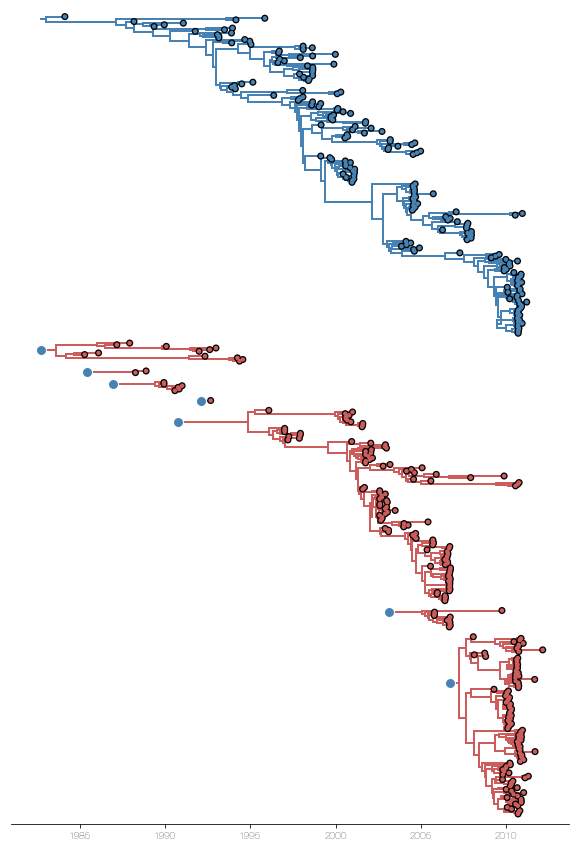

In [7]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')

traitName='PB1'
tipSize=20

cumulative_y=0

x_attr=lambda k: k.absoluteTime
c_func=lambda k: 'indianred' if k.traits[traitName]=='V' else 'steelblue'
s_func=lambda k: tipSize
z_func=lambda k: 100

su_func=lambda k: tipSize+30
cu_func=lambda k: 'k'
zu_func=lambda k: 99

for subtype in ['V','Y']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        y_attr=lambda k: k.y+cumulative_y
        
        loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour_function=c_func)
        loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size_function=s_func,
                            colour_function=c_func,zorder_function=z_func)
        loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size_function=su_func,
                            colour_function=cu_func,zorder_function=zu_func)
        
        oriC='indianred' if origin=='V' else 'steelblue'
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        cumulative_y+=loc_tree.ySpan+5 ## increment y displacement
        
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)

plt.show()

## Reduced trees
--------
This bit shows how to recover and plot reduced trees, which have a subset of the tips from the full tree, but preserve the evolutionary history that left over tips descend from.

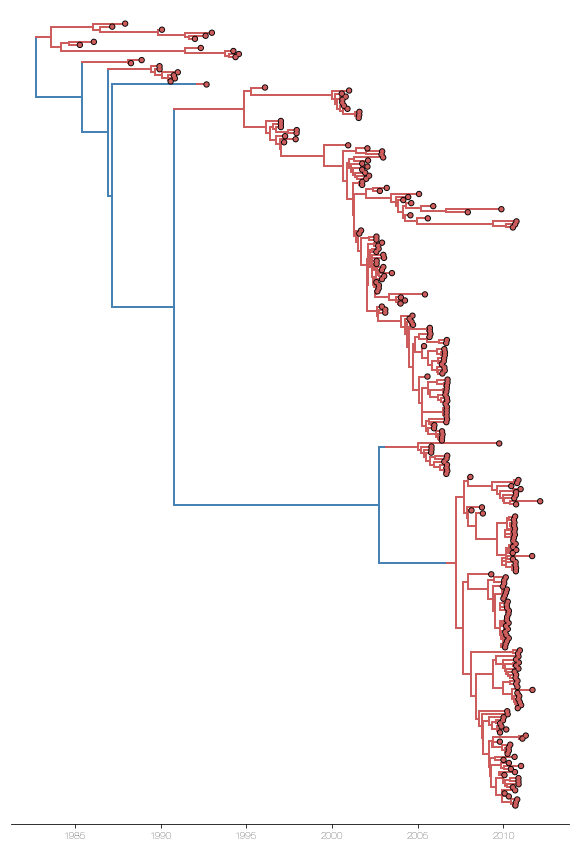

In [8]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')

traitName='PB1'
tipSize=20

cumulative_y=0
keep_tips=[k for k in ll.Objects if k.branchType=='leaf' and k.traits['PB1']=='V'] ## list of leaf objects that will remain in the tree
reduced_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)

x_attr=lambda k: k.absoluteTime
c_func=lambda k: 'indianred' if k.traits['PB1']=='V' else 'steelblue'
s_func=lambda k: tipSize
z_func=lambda k: 100

cu_func=lambda k: 'k'
su_func=lambda k: tipSize*2
zu_func=lambda k: 99

reduced_tree.plotTree(ax,x_attr=x_attr,colour_function=c_func)
reduced_tree.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=c_func,zorder_function=z_func)
reduced_tree.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-5,reduced_tree.ySpan+5)

plt.show()

## Turning a tree data structure into a string

baltic can convert the data structure contained within the tree class to a tree string, with options to include the numName (the name of the tip as it appeared in the tree string) or the name attribute (if tips were decoded from their BEAST encoding) for tips and the inclusion of BEAST annotations.

In [9]:
traitCombos=[['posterior'],None,['PB1','PB2','HA','PB1.set','PB1.set.prob'],['length','length_95%_HPD'],['height','height_95%_HPD']]
numNames=[True,False,True,False,True]

for subtree,traitCombo,outputWithNumber in zip(subtype_trees['V'],traitCombos,numNames):
    origin,sbtr=subtree
    sbtr.singleType() ## within-trait traversal may result in multitype trees - many software packages won't take those, so we're turning each subtree into a singletype tree

    print 'Number of objects in subtree: %d, annotations to include: %s, use number encoding for tips: %s'%(len(sbtr.Objects),traitCombo,outputWithNumber)

    print '%s\n\n'%(sbtr.toString(traits=traitCombo,numName=outputWithNumber,nexus=True,verbose=False)) ## can output to a minimal NEXUS format for viewing in figtree with correct trait parsing

Number of objects in subtree: 11, annotations to include: ['posterior'], use number encoding for tips: True
#NEXUS
Begin trees;
tree TREE1 = [&R] ('16':0.519606,('15':0.292285,('84':0.896462,('285':0.332987,('150':0.313269,'425':0.065022)[&posterior=0.28885679369]:0.081792)[&posterior=1.0]:0.330872)[&posterior=1.0]:0.458146)[&posterior=0.221308743473]:0.230951)[&posterior=1.0]:2.477703;
End;


Number of objects in subtree: 1, annotations to include: None, use number encoding for tips: False
#NEXUS
Begin trees;
tree TREE1 = [&R] 'B/Hong_Kong/02/1993_1993-02-15'[&NS.set={"V"},HA.prob=1.0,PB2r_range={0.00155602915744,0.0484531532328},IB_NP.rate_95%_HPD={0.000495073262159,0.00276659300119},NAr_95%_HPD={0.0062222242243,0.0500559735988},height=19.455184839,MPr_range={2.26225220652e-05,0.0978061955664},PB1r_range={0.00269829285707,0.0510912132659},PB2.prob=1.0,NAr_median=0.0238544897775,length_95%_HPD={0.0427725613566,1.49216595016},PB2r=0.0139373602831,HA="V",NSr=0.0545824712286,PA.set.prob=

## Tree transformations
------
This next bit plots the tree in terms of the trait transitions that take place within it. Trait space is where things get plotted, but other dimensions, such as time, can be represented with colour or line width, as desired. I've also added code to do Bezier curves, which I think are an amazing tool in a scientist's arsenal, mostly because they can be customised to prevent overlapping with each other and to highlight links between closely positioned points.

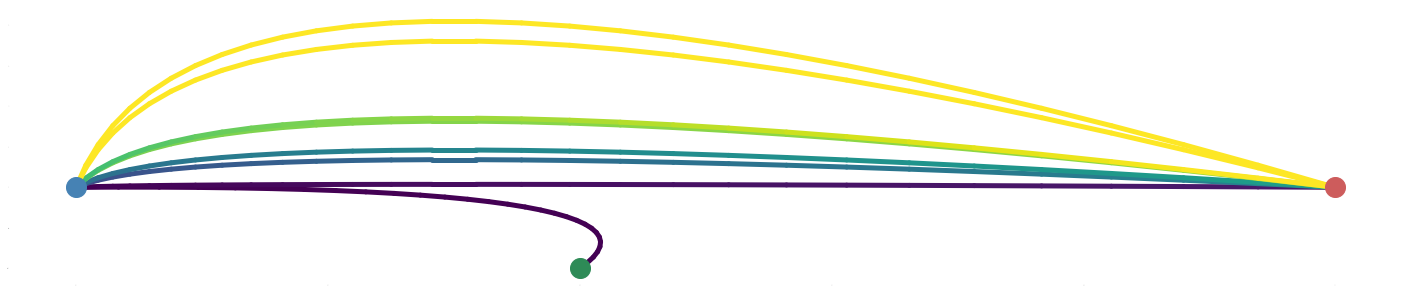

In [10]:
fig,ax = plt.subplots(figsize=(25,5),facecolor='w')

cmap=mpl.cm.viridis
coords={
        'V':(1,0),
        'Y':(0,0),
        'ancestor':(0.4,-10)
       } ## coordinates for trait values

## plot traits as points
ax.scatter(coords['V'][0],coords['V'][1],s=400,facecolor='indianred',zorder=99999999)
ax.scatter(coords['Y'][0],coords['Y'][1],s=400,facecolor='steelblue',zorder=99999999)
ax.scatter(coords['ancestor'][0],coords['ancestor'][1],s=400,facecolor='seagreen',zorder=99999999)

for k in ll.Objects: ## iterate over objects in tree
    ct=k.traits[traitName] ## fetch current and parent traits
    pt=k.parent.traits[traitName]
    if ct!=pt: ## if they don't match - a switch happened
        
        P1=coords[pt] ## fetch coordinates of points
        P2=coords[ct]
        
        begin=k.parent.height ## fetch heights of node and its parent
        end=k.height
        
        mid_frac=(end+begin)/2.0/ll.treeHeight ## calculate the fractional height of middle of transitioning branch in tree
        
        if pt!='ancestor':
            control=Bezier_control(P1,P2,mid_frac*20,0.1) ## if dealing with a regular transition - control point is positioned according to fractional height of transition
        else:
            control=(0.5,0.5) ## if dealing with transition from ancestral state to regular states position control point in the middle
#         curve=Bezier([P1,control,P2],0.0,1.0,num=30) ## get Bezier curve coordinates
        
        control_point_locs=np.array([P1,control,P2])
        control_point_locs=control_point_locs.transpose() ## reshape so x coords are in one array, y in another
        curve=bezier.Curve(control_point_locs,2)
        
        xs,ys=curve.evaluate_multi(np.linspace(0,1,30))
        for f in range(len(xs)-1): ## iterate over segments of the line
            x1,y1=xs[f],ys[f]
            x2,y2=xs[f+1],ys[f+1]
            frac=f/float(len(xs)) 

            ax.plot([x1,x2],[y1,y2],lw=5,color=cmap((begin+(end-begin)*frac)/ll.treeHeight),zorder=int(mid_frac*10000),solid_capstyle='round') ## plot each segment individually, colouring according to what fraction of the tree the segment traversed in time

ax.tick_params(size=0,labelsize=0)
[ax.spines[side].set_visible(False) for side in ax.spines]
plt.show()

## Tangled chains (sequential tanglegrams)
-------
The following code imports a bunch of trees, collapses nodes, plots them end to end coloured by the trait value of the first tree and connects the same tips by lines that follow the order of tips in the first tree.

In [11]:
segments=['PB1','PB2','PA','HA','NP','NA','M1','NS1']

trees={} ## dict
for segment in segments:
    print segment,
    address=r'https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%%20trees/InfB_%st_ALLs1.mcc.tre'%(segment) ## address of example tree
    
    fetch_tree = requests.get(address) ## fetch tree
    treeFile=StringIO(fetch_tree.text) ## stream from repo copy
    
    ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file
    trees[segment]=ll.collapseBranches(lambda k:k.traits['posterior']<0.5) ## add tree object to dict
    trees[segment]=trees[segment].reduceTree([k for k in ll.Objects if k.branchType=='leaf' and k.numName in map(str,range(0,452,5))]) ## reduce tree to every 5th tip, to make plotting faster later
    
print '\nDone!'

PB1 PB2 PA HA NP NA M1 NS1 
Done!


Each neighbouring tree first needs to be iteratively untangled as much as possible.

In [12]:
tip_positions={x:{} for x in segments} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

tip_positions={x:{} for x in trees} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

for X in range(10): ## 10 untangling iterations
    print 'iteration %d'%(X+1)
    for t,tr in enumerate(segments): ## iterate over each tree
        print tr
        ptr=segments[t-1] ## previous tree
        ntr=segments[t] ## next tree
        seg=trees[ptr] ## fetch appropriate tree
        nex_seg=trees[ntr]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height): ## iterate over branches from most recent to oldest
            if k.branchType=='node': ## can only sort nodes
                leaves=[[seg.tipMap[tip] for tip in w.leaves if tip in seg.tipMap] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
#                 leaves=[[seg.tipMap[tip] for tip in w.leaves] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
                for c in range(len(leaves)):
#                     leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1]) ## sort leaves according to their positions in the next tree
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1] if x in tip_positions[ntr] else 0.0) ## sort leaves according to their positions in the next tree
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl if w in tip_positions[ntr]]) for cl in leaves] ## extract y positions of descendents
                merge_ys=sum(ys,[]) ## flatten list of tip y coordinates
                ypos=range(min(merge_ys),max(merge_ys)+1) ## get y positions of tips in current order
                order={i:x for i,x in enumerate(leaves)} ## dict of tip order: tip name
                
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(min([len(order[x]),len(ypos)])) if order[x][w] in tip_positions[ptr]])) ## get new order by sorting existing order based on y position differences
                
#                 new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(len(order[x]))])) ## get new order by sorting existing order based on y position differences
                
                if new_order!=range(len(leaves)): ## if new order is not current order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects: ## iterate over objects in next tree
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions
                
        if t==0: ## if first tree
            trees[segments[t]].drawTree() ## update positions
            lvs=sorted([w for w in trees[segments[t]].Objects if w.branchType=='leaf'],key=lambda x:x.y) ## get leaves in y position order
            
            norm=mpl.colors.Normalize(0,len(lvs))
            pos_colours={w.name:cmap(norm(w.y)) for w in lvs} ## assign colour

iteration 1
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 2
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 3
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 4
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 5
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 6
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 7
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 8
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 9
PB1
PB2
PA
HA
NP
NA
M1
NS1
iteration 10
PB1
PB2
PA
HA
NP
NA
M1
NS1


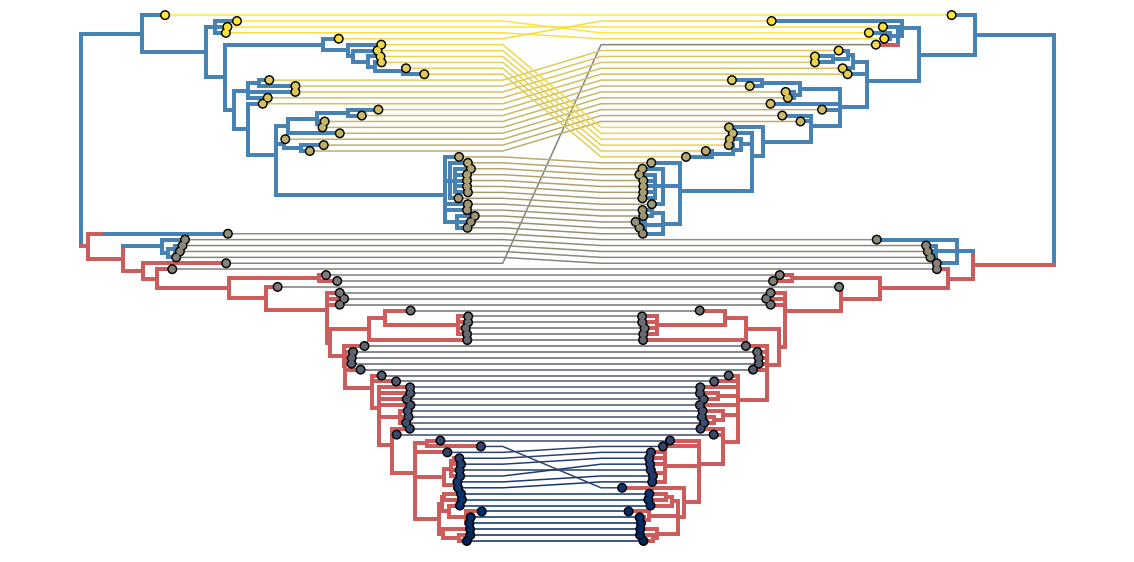

In [13]:
fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

traitName='HA'
tree1=trees['PB1']
tree2=trees['PB2']

cmap=mpl.cm.cividis
x_attr=lambda k: k.height ## branch x position is determined by height
b_func=lambda k: 4 ## branch width function
s_func=lambda k: 50 ## size of circle at tips
su_func=lambda k: 100 ## size of circle that sits underneath and acts as an outline
c_func=lambda k: 'indianred' if k.traits[traitName]=='V' else 'steelblue'
ct_func=lambda k: cmap(k.y/float(tree1.ySpan)) ## call colour map with fraction that represents the y position of a tip (returns colour)
cu_func=lambda k: 'k' ## colour of circle sitting underneath the tip one is always black
z_func=lambda k: 100
zu_func=lambda k: 99
tree1.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=c_func) ## plot tree
tree1.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=ct_func,zorder_function=z_func) ## plot tip circle
tree1.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## plot tip circle outline (another circle underneath)

skip=tree1.treeHeight*0.35 ## skip this many units between trees
x_attr=lambda k: tree1.treeHeight+skip+tree2.treeHeight-k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches
tree2.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=c_func) ## plot black tree
tree2.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=ct_func,zorder_function=z_func) ## plot circles at tips
tree2.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func) ## plot circles underneath tip circles as an outline

for k in filter(lambda x: x.branchType=='leaf',tree1.Objects): ## grab leaf objects in tree1
    x=k.height ## get height
    y=k.y ## get y position
    
    matching_tip=tree2.getBranches(lambda x: x.branchType=='leaf' and x.name==k.name) ## fetch corresponding branch in tree2
    match_y=matching_tip.y
    xs=[x,tree1.treeHeight+0.15*skip,tree1.treeHeight+skip-0.15*skip,x_attr(matching_tip)] ## x coordinates for tangleline
    ys=[y,y,match_y,match_y] ## y coordinates for tangleline
    ax.plot(xs,ys,color=cmap(y/float(tree1.ySpan))) ## plot tangleline
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-1,tree1.ySpan+1) ## set y limits
ax.set_xlim(-5,tree1.treeHeight+skip+tree2.treeHeight+5)

plt.show()

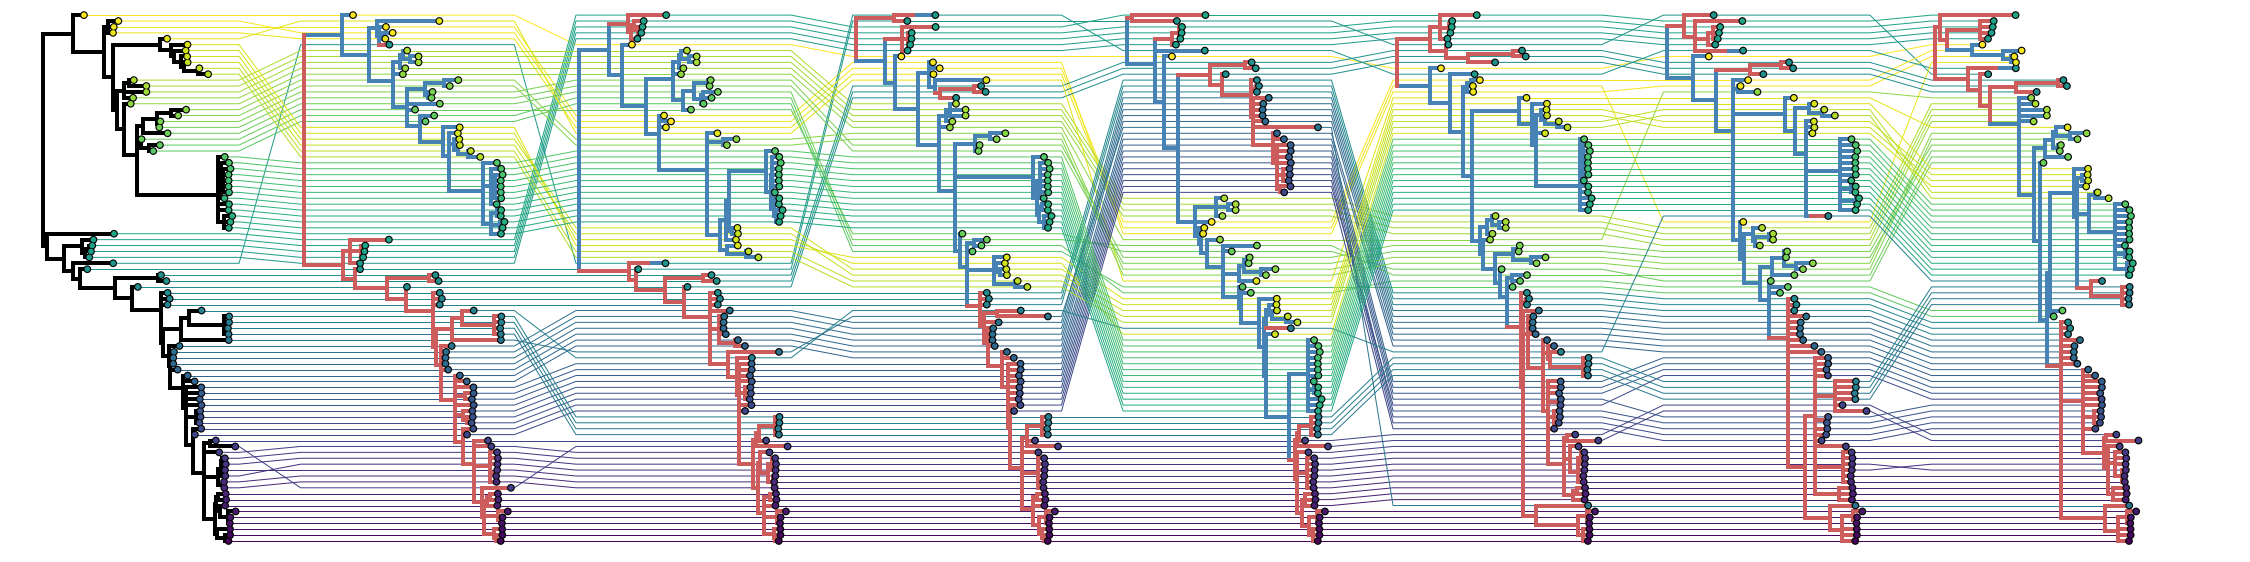

In [14]:
fig,ax = plt.subplots(figsize=(40,10),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by
cmap=mpl.cm.viridis
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

tree_names=['PB1','PB2','HA','PA','NP','NA','M1','NS1'] ## define order in which dict will be accessed

displaceAmount=10
for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
#     print [k.height for k in cur_tree.Objects]
    x_attr=lambda k: k.height+cumulative_displace
    
    b_func=lambda k: 4
    s_func=lambda k: 30
    su_func=lambda k: 60
    ct_func=lambda k: cmap(tip_positions['PB1'][k.name][1]/float(cur_tree.ySpan))
    cu_func=lambda k: 'k'
    z_func=lambda k: 100
    zu_func=lambda k: 99
    
    def colour_func(node):
        if traitName in node.traits:
            return 'indianred' if node.traits[traitName]=='V' else 'steelblue'
        else:
            return 'k'
        
    cn_func=colour_func
    
    cur_tree.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=cn_func)
    cur_tree.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=ct_func,zorder_function=z_func)
    cur_tree.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)
    
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,bt.leaf): ## if leaf...
            y=k.y
            pos_in_first_tree=tip_positions['PB1'][k.name][1] ## fetch y coordinate of same tip in the first tree
            frac_pos=pos_in_first_tree/float(cur_tree.ySpan) ## normalize coordinate to be within interval [0.0,1.0]

            if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                next_x+=cumulative_displace+cur_tree.treeHeight+displaceAmount ## adjust x coordinate by current displacement and future displacement
                nextIncrement=cumulative_displace+cur_tree.treeHeight
                ax.plot([x_attr(k),nextIncrement+0.05*displaceAmount,nextIncrement+0.95*displaceAmount,next_x],[y,y,next_y,next_y],lw=1,ls='-',color=cmap(frac_pos),zorder=0) ## connect current tip with same tip in the next tree
    
    cumulative_displace+=cur_tree.treeHeight+displaceAmount ## increment displacement by the height of the tree

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-1,cur_tree.ySpan+1) ## set y limits
ax.set_xlim(-5,cumulative_displace+5)

plt.show()

## Radial trees and shutter plots
-----
The cell below shows code that can be used to plot radial trees, in addition to code that could be used to plot a series of trees in a circle facing inwards with a particular isolate highlighted in all plotted phylogenies. This was a suggestion proposed by Anne-Mieke Vandamme at the amazing Virus Genomics and Evolution (#VGE16) meeting in Cambridge in June 2016.

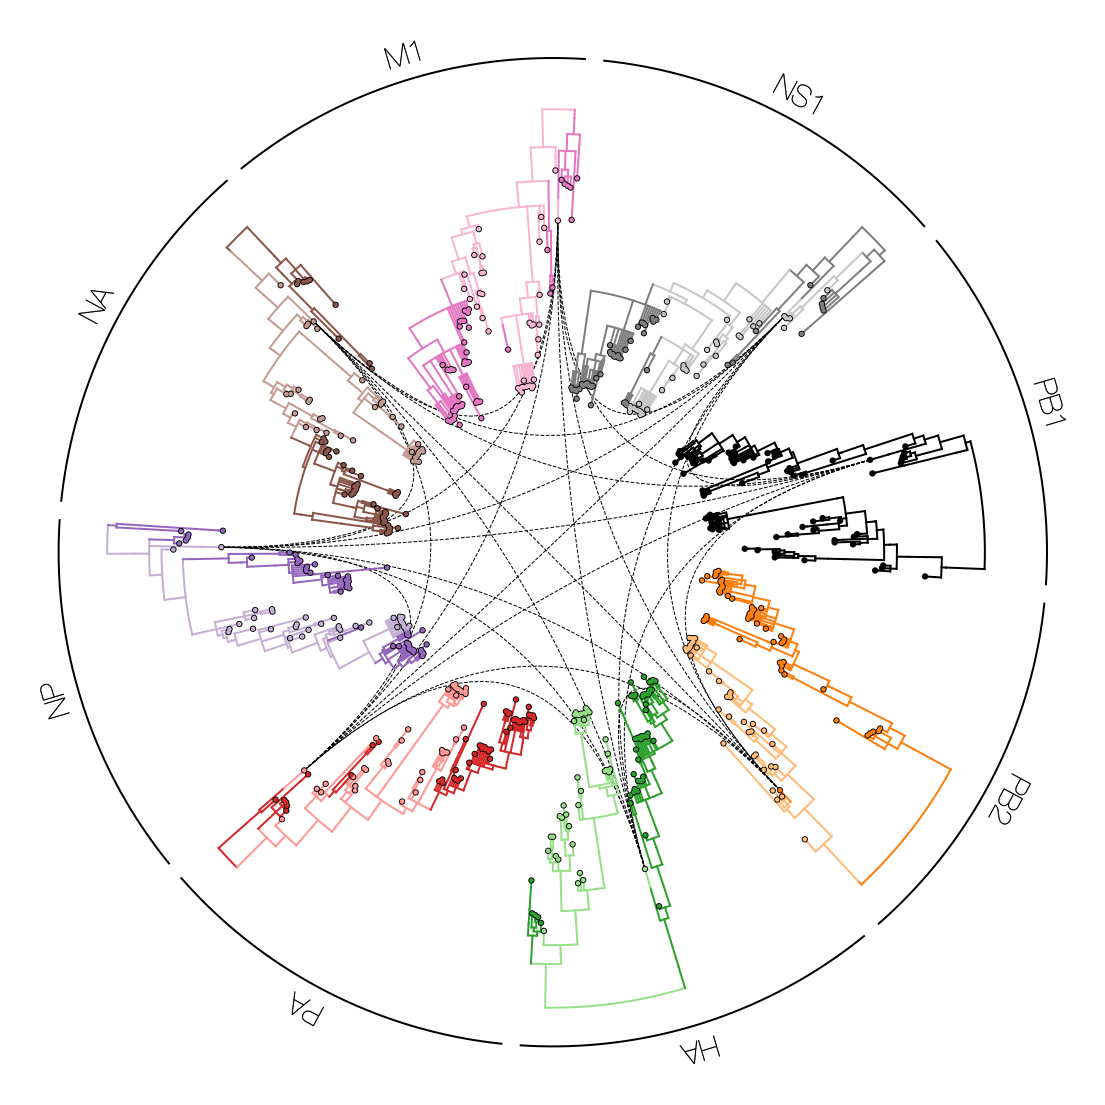

In [15]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by

branchWidth=2 ## default branch width

# inwardSpace=-1.15 ## determines how much space is left in the middle, if negative (and >1) trees are plotted pointing outwards
inwardSpace=0.5
gap=0.95 ## determines how much of their allocated space along the circle a tree uses

tree_names=['PB1','PB2','HA','PA','NP','NA','M1','NS1'] ## define order in which dict will be accessed
# tree_names=['PB1','PB2','HA','PA','NP'] ## define order that makes a pentagram
# tree_names=['PB1','PB2','HA'] ## define order that plots coevolving segments
# tree_names=['PB1','HA'] ## define order that plots two trees

cmap=mpl.cm.tab20 ## choose a colour map
vega_colours={tree:[cmap((t*2)/20.0),cmap((t*2+1)/20.0)] for t,tree in enumerate(tree_names)}

circFrac=1/float(len(tree_names)) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle

all_tips=[r.name for r in trees['PB1'].Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip

foci=[all_tips[randomTip]] ## set it as focus - any tips listed here will be connected in a tanglegram-y way

controlDepth=max([trees[treeName].treeHeight for treeName in tree_names]) ## find the height of the highest tree

effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

for t,tr in enumerate(tree_names): ## iterate over trees
    baseCircle=2*np.pi*startFrom ## tree starts here along the circle
    
    cur_tree=trees[tr] ## fetch tree

    leaves=[w.name for w in cur_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
    leafCount=len(leaves) ## count leaves in the tree
    mostRecent=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip
    
    if inwardSpace<0.0:
        labelX=-abs(inwardSpace)*1.05
    else:
        labelX=inwardSpace+1.05
    labelY=baseCircle+circFrac*np.pi
    
    ax.text(np.sin(labelY)*labelX*1.1,np.cos(labelY)*labelX*1.1,'%s'%(tr),size=30,rotation=-np.rad2deg(labelY),va='center',ha='center',path_effects=effects)
    
    treeBar=np.linspace(baseCircle,baseCircle+2*gap*circFrac*np.pi,40)
    ax.plot(np.sin(treeBar)*labelX*1.05,np.cos(treeBar)*labelX*1.05,lw=2,ls='-',color='k')
    
    for k in cur_tree.Objects: ## iterate through objects in the tree
        y=k.y ## get y position of current object
        x=k.absoluteTime ## get x position of current object
        xp=k.parent.absoluteTime ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        ## once a tree is circular (or radial) the x coordinate is transformed into a coordinate along a circle of a bigger or smaller diameter
        # this is done by starting from the inward space, and plotting things deeper in time outwards
        xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
        xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate

        ## circularisation of the tree depends on transforming y coordinates into positions along a circle
        # this is done by specifying a position that is a fraction along a circle of length 2*pi
        # such coordinates are then plotted using sin(y) and cos(y) to get x and y coordinates along a circle, respectively
        yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate
        
        if k.traits.has_key(traitName): ## if tree has PB1 trait - colour accordingly
            c=[vega_colours[tr][0] if k.traits[traitName]=='V' else vega_colours[tr][1]][0] ## pick from colour pairs
        else: ## otherwise - black
            c='k'
            
        if isinstance(k,bt.leaf): ## if leaf...
            s=20
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip, notice that coordinates that were y coordinates are now transformed with sin and cos and previous x coordinate is used to scale the circle up
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            if k.name in foci: ## if tip is one of the wanted tips for tanglegram
                p1=(np.sin(yc)*xc , np.cos(yc)*xc) ## get actual plot coordinates of origin tip along circle for a tanglegram connection
                
                startFrom2=startFrom ## start circle positioning based on current position
                for nex in range(t,len(tree_names)): ## iterate over other trees
                    if nex>t: ## only start at the next tree
                        nex_tree=trees[tree_names[nex]] ## fetch next tree
                        baseCircle2=2*np.pi*startFrom2
                        leaves2=[w.name for w in nex_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the next tree
                        leafCount2=len(leaves2) ## count leaves in next tree
                        mostRecent2=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip in the next tree
                        
                        for h in nex_tree.Objects: ## iterate through objects in next tree
                            if isinstance(h,bt.leaf) and h.name==k.name: ## if at the same tip...
                                y2=h.y ## get y position
                                x2=h.absoluteTime ## get x position
                                xp2=h.parent.absoluteTime ## get x position of current object's parent

                                if x2==None: ## matplotlib won't plot Nones, like root
                                    x2=0.0
                                if xp2==None:
                                    xp2=x2

                                xc2=inwardSpace+((mostRecent2-x2)/controlDepth) ## transform x coordinate of object in next tree
                                xpc2=inwardSpace+((mostRecent2-xp2)/controlDepth) ## transform x parent's coordinate in next tree
                                yc2=baseCircle2+circFrac*np.pi*2*(y2/float(leafCount2))*gap ## transform y coordinate in next tree

                                p2=(np.sin(yc2)*xc2,np.cos(yc2)*xc2) ## get actual plot coordinate of target tip in next tree
                                
                                bez_points=np.array([p1,(0.0,0.0),p2]).transpose()
                                xs,ys=bezier.Curve(bez_points,2).evaluate_multi(np.linspace(0,1,30))
                                ax.plot(xs,ys,color='k',ls='--',lw=1) ## plot Bezier curve

                    startFrom2+=circFrac ## increment to next tree
            
        elif isinstance(k,bt.node): ## if node...
            yl=k.children[-1].y ## fetch first child y coordinate
            yr=k.children[0].y ## fetch last child y coordinate

            ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
            ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child

            ybar=np.linspace(ycl,ycr,15) ## create a curved bar

            ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=9) ## plot curved bar at the base of a node

        ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=9) ## plot ancestral branch
    
    startFrom+=circFrac ## increment position along circle for next tree

# ax.set_xlim(-inwardSpace*1.1,inwardSpace*1.1) ## plot limits
# ax.set_ylim(-inwardSpace*1.1,inwardSpace*1.1)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_aspect(1) ## aspect set to 1 for proper circular plot
plt.show()

This cell re-orients the tree such that time now follows the circle.

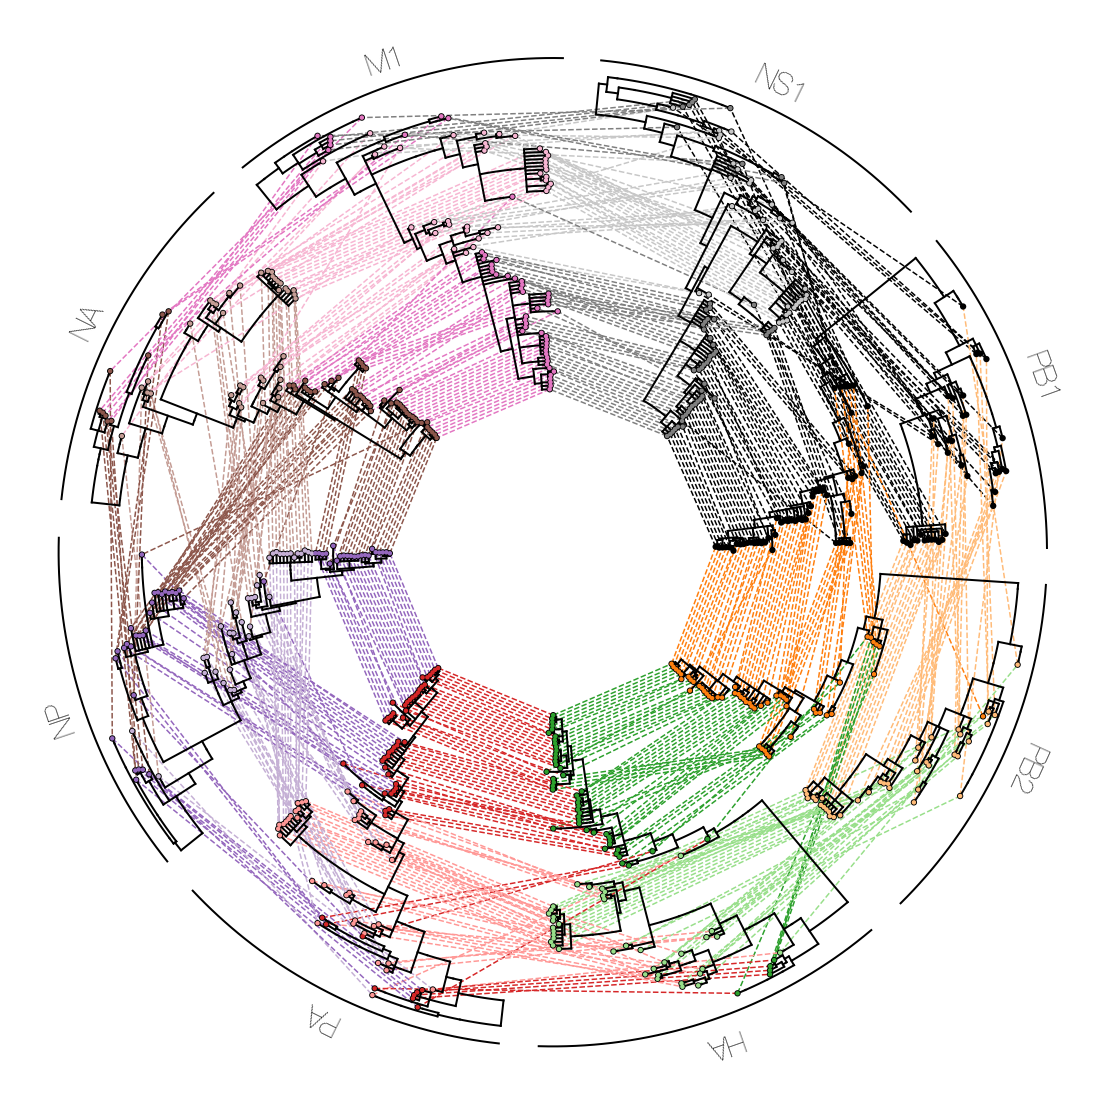

In [16]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by

branchWidth=2 ## default branch width

# inwardSpace=-1.15 ## determines how much space is left in the middle, if negative (and >1) trees are plotted radiating outwards
inwardSpace=0.5
gap=0.9 ## determines how much of their allocated space along the circle a tree uses

tree_names=['PB1','PB2','HA','PA','NP','NA','M1','NS1'] ## define order in which dict will be accessed
# tree_names=['PB1','PB2','HA','PA','NP'] ## define order that makes a pentagram
# tree_names=['PB1','PB2','HA'] ## define order that plots coevolving segments
# tree_names=['PB1','HA'] ## define order that plots two trees

cmap=mpl.cm.tab20 ## choose a colour map
vega_colours={tree:[cmap((t*2)/20.0),cmap((t*2+1)/20.0)] for t,tree in enumerate(tree_names)}

totalCircle=sum([trees[treeName].treeHeight for treeName in tree_names]) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle

all_tips=[r.name for r in trees['PB1'].Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip

foci=[all_tips[randomTip]] ## set it as focus - any tips listed here will be connected in a tanglegram-y way

controlDepth=len(trees[tree_names[0]].Objects)/2 ## find the height of the highest tree along y axis

for t,tr in enumerate(tree_names): ## iterate over trees
    baseCircle=2*np.pi*startFrom ## tree starts here along the circle
    
    cur_tree=trees[tr] ## fetch tree
    circFrac=cur_tree.treeHeight/totalCircle
    leaves=[w.name for w in cur_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
    leafCount=len(leaves) ## count leaves in the tree
    mostRecent=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip
    
    if inwardSpace<0.0:
        labelX=-abs(inwardSpace)*1.05
    else:
        labelX=inwardSpace+1.05
    labelY=baseCircle+circFrac*np.pi*gap
    
    ax.text(np.sin(labelY)*labelX*1.05,np.cos(labelY)*labelX*1.05,'%s'%(tr),size=30,rotation=-np.rad2deg(labelY),va='center',ha='center')
    
    treeBar=np.linspace(baseCircle,baseCircle+2*gap*circFrac*np.pi,40)
    ax.plot(np.sin(treeBar)*labelX,np.cos(treeBar)*labelX,lw=2,ls='-',color='k')
    
    for k in cur_tree.Objects: ## iterate through objects in the tree
        y=k.y ## get y position of current object
        x=k.absoluteTime ## get x position of current object
        xp=k.parent.absoluteTime ## get x position of current object's parent
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        ## once a tree is circular (or radial) the y coordinate is transformed into a coordinate along a circle of a bigger or smaller diameter
        # this is done by starting from the inward space, and plotting things higher or lower along the circle
        yc=inwardSpace+y/float(leafCount) ## transform y coordinate

        ## circularisation of the tree depends on transforming x coordinates into positions along a circle
        # this is done by specifying a position that is a fraction along a circle of length 2*pi
        # such coordinates are then plotted using sin(x) and cos(x) to get y and x coordinates along a circle, respectively
        xc=baseCircle+circFrac*np.pi*2*(k.height/float(cur_tree.treeHeight))*gap ## transform x coordinate
        xpc=baseCircle+circFrac*np.pi*2*(k.parent.height/float(cur_tree.treeHeight))*gap ## transform x parent's coordinate
        
        xbar=np.linspace(xpc,xc,15)

        if k.traits.has_key(traitName): ## if tree has trait - colour accordingly
            c=[vega_colours[tr][0] if k.traits[traitName]=='V' else vega_colours[tr][1]][0]
        else: ## otherwise - black
            c='k'
            
        if isinstance(k,bt.leaf): ## if leaf...
            s=20
            tc=c
            
            ax.scatter(np.sin(xc)*yc,np.cos(xc)*yc,s=s,facecolor=tc,edgecolor='none',zorder=11) ## plot circle for every tip, notice that coordinates that were x coordinates are now transformed with sin and cos and previous y coordinate is used to scale the circle up
            ax.scatter(np.sin(xc)*yc,np.cos(xc)*yc,s=2*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            ## commenting out the following block to skip tanglegrams
            nex_tree=trees[tree_names[t-1]]
            for l in nex_tree.Objects:
                if isinstance(l,bt.leaf) and l.name==k.name:
                    #baseCircle2=startFrom-(nex_tree.treeHeight/totalCircle)
                    nexCircFrac=nex_tree.treeHeight/totalCircle
                    nxc=2*np.pi*(startFrom-nexCircFrac)+np.pi*2*nexCircFrac*(l.height/float(nex_tree.treeHeight))*gap ## transform y coordinate
                    nyc=inwardSpace+l.y/float(leafCount)
                    
                    ax.plot([np.sin(xc)*yc,np.sin(nxc)*nyc],[np.cos(xc)*yc,np.cos(nxc)*nyc],color=tc,ls='--',zorder=8)
            
        elif isinstance(k,bt.node): ## if node...
            yl=k.children[-1].y ## fetch first child y coordinate
            yr=k.children[0].y ## fetch last child y coordinate

            ycl=inwardSpace+yl/float(leafCount)
            ycr=inwardSpace+yr/float(leafCount)
            
            ax.plot([np.sin(xc)*ycl,np.sin(xc)*ycr],[np.cos(xc)*ycl,np.cos(xc)*ycr],lw=branchWidth,color='k',ls='-',zorder=9)

        ax.plot(np.sin(xbar)*yc,np.cos(xbar)*yc,lw=branchWidth,color='k',ls='-',zorder=9) ## plot ancestral branch
    
    startFrom+=circFrac ## increment position along circle for next tree

# ax.set_xlim(-inwardSpace*1.1,inwardSpace*1.1) ## plot limits
# ax.set_ylim(-inwardSpace*1.1,inwardSpace*1.1)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_aspect(1) ## aspect set to 1 for proper circular plot
plt.show()

## Multitype trees

baltic now has the ability to deal with multitype trees recovered as part of structured coalescent analyses, which contain nodes with a single child. You can find an example of the files you might find after running a structured coalescent analysis in beast2 [here](https://github.com/Taming-the-BEAST/Structured-coalescent/).


Tree height: 6.636090
Tree length: 35.270573
multitype tree
annotations present

Numbers of objects in tree: 129 (69 nodes and 60 leaves)



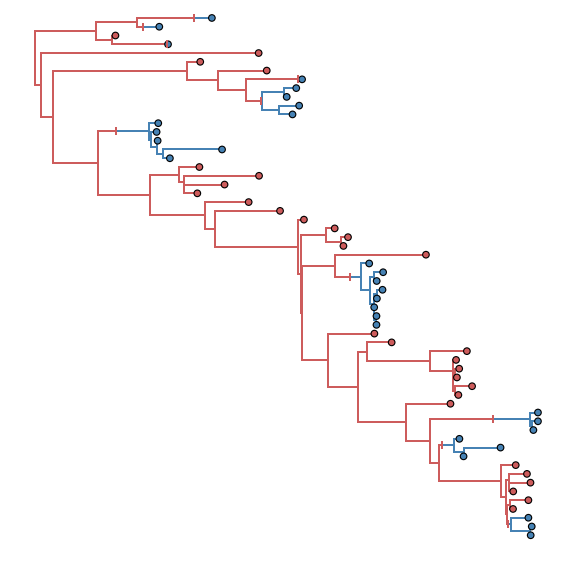

In [17]:
address='https://raw.githubusercontent.com/Taming-the-BEAST/Structured-coalescent/master/precooked_runs/MTT.h3n2_2deme.map.trees' ## address of example tree
fetch_tree = requests.get(address) ## fetch tree
treeFile=StringIO(fetch_tree.text) ## stream from repo copy

mtt=bt.loadNexus(treeFile,absoluteTime=False) ## treeFile here can alternatively be a path to a local file
mtt.treeStats() ## report stats about tree
mtt.sortBranches()

fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

c_func=lambda k: 'indianred' if k.traits['type']=='HongKong' else 'steelblue'
s_func=lambda k: 30
z_func=lambda k: 100

n_target=lambda k: k.branchType=='node' and len(k.children)==1
sn_func=lambda k: 50
zn_func=lambda k: 101

cu_func=lambda k: 'k'
su_func=lambda k: 60
zu_func=lambda k: 99

mtt.plotTree(ax,colour_function=c_func)

kwargs={'marker':'|','lw':2}
mtt.plotPoints(ax,target=n_target,size_function=sn_func,colour_function=c_func,zorder_function=zn_func,**kwargs)

mtt.plotPoints(ax,size_function=s_func,colour_function=c_func,zorder_function=z_func)
mtt.plotPoints(ax,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

ax.set_ylim(-1,mtt.ySpan+1)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

## Collapsing clades

baltic allows subtrees to be collapsed. When given a node object the collapseSubtree function will replace that node and any of its descendants with a clade object. These pose as tips, but contain attributes that allow the clade object to be plotted in a way that can represent how many tips were present in the collapsed clade or when the most recent tip of the collapsed subtree existed.

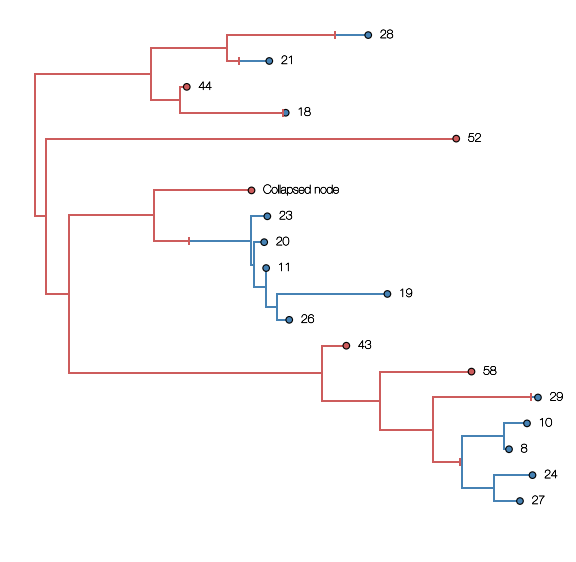

In [18]:
fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

branchWidth=2 ## default branch width

ancestor=mtt.commonAncestor(['37','46'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node',widthFunction=lambda x:1) ## the width function transforms the number of descendant tips that the node had into an amount of vertical space that the clade will receive in the plotted tree
mtt.sortBranches()

effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

c_func=lambda k: 'indianred' if k.traits['type']=='HongKong' else 'steelblue'
s_func=lambda k: 30
z_func=lambda k: 100

n_target=lambda k: k.branchType=='node' and len(k.children)==1
sn_func=lambda k: 50
zn_func=lambda k: 101

cu_func=lambda k: 'k'
su_func=lambda k: 60
zu_func=lambda k: 99

mtt.plotTree(ax,colour_function=c_func)

kwargs={'marker':'|','lw':2}
mtt.plotPoints(ax,target=n_target,size_function=sn_func,colour_function=c_func,zorder_function=zn_func,**kwargs)

mtt.plotPoints(ax,size_function=s_func,colour_function=c_func,zorder_function=z_func)
mtt.plotPoints(ax,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

pos_func=lambda k: (k.x+30/365.0,k.y)
text_func=lambda k: k.numName
kwargs={'ha':'left','va':'center','size':12,'path_effects':effects}
mtt.addText(ax,position=pos_func,text=text_func,**kwargs)

ax.set_ylim(-1,mtt.ySpan+1)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

6.52640916786


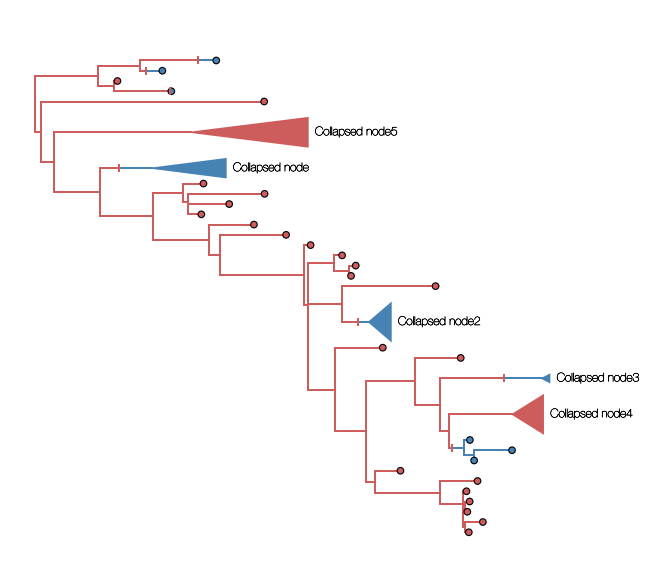

In [19]:
mtt.uncollapseSubtree() ## reset tree by uncollapsing clades

ancestor=mtt.commonAncestor(['23','26'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node',widthFunction=lambda x:len(x.leaves)/2)
ancestor=mtt.commonAncestor(['22','25'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node2',widthFunction=lambda x:len(x.leaves)/2)
ancestor=mtt.commonAncestor(['30','16'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node3',widthFunction=lambda x:len(x.leaves)/2)
ancestor=mtt.commonAncestor(['34','14'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node4',widthFunction=lambda x:len(x.leaves)/2)
ancestor=mtt.commonAncestor(['43','27'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node5',widthFunction=lambda x:len(x.leaves)/2)

mtt.traverse_tree()
mtt.sortBranches()

print mtt.treeHeight

fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

t_target=lambda k: isinstance(k,bt.leaf)
c_func=lambda k: 'indianred' if k.traits['type']=='HongKong' else 'steelblue'
s_func=lambda k: 30
z_func=lambda k: 100

n_target=lambda k: k.branchType=='node' and len(k.children)==1
sn_func=lambda k: 50
zn_func=lambda k: 101

cu_func=lambda k: 'k'
su_func=lambda k: 60
zu_func=lambda k: 99

mtt.plotTree(ax,colour_function=c_func)

kwargs={'marker':'|','lw':2}
mtt.plotPoints(ax,target=n_target,size_function=sn_func,colour_function=c_func,zorder_function=zn_func,**kwargs)

mtt.plotPoints(ax,target=t_target,size_function=s_func,colour_function=c_func,zorder_function=z_func)
mtt.plotPoints(ax,target=t_target,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

c_target=lambda k: isinstance(k,bt.clade)
pos_func=lambda k: (k.lastHeight+30/365.0,k.y)
text_func=lambda k: k.numName
kwargs={'ha':'left','va':'center','size':12,'path_effects':effects}
mtt.addText(ax,target=c_target,position=pos_func,text=text_func,**kwargs)

for k in mtt.Objects: ## iterate over objects in tree
    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=k.x
        y=k.y
        c='indianred' if k.traits['type']=='HongKong' else 'steelblue'
        clade=plt.Polygon(([x,y-0.001*len(mtt.Objects)],[x,y+0.001*len(mtt.Objects)],[k.lastHeight,y+k.width/2.0],[k.lastHeight,y-k.width/2.0]),facecolor=c,edgecolor='none',zorder=12) ## define a triangle polygon
        ax.add_patch(clade)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
    
ax.set_ylim(-1,mtt.ySpan+5)
plt.show()

Unrooted trees can now be drawn too.

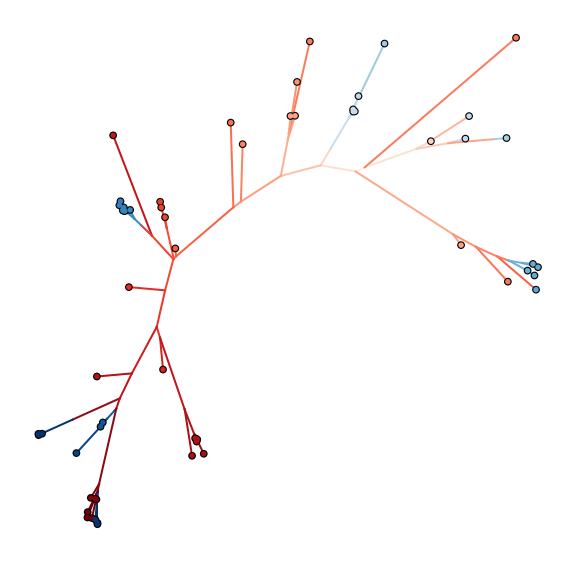

In [20]:
mtt.uncollapseSubtree() ## uncollapse
mtt.drawUnrooted() ## draw tree as unrooted

fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

c_func=lambda k: mpl.cm.Reds(k.height/mtt.treeHeight) if k.traits['type']=='HongKong' else mpl.cm.Blues(k.height/mtt.treeHeight)
s_func=lambda k: 30
z_func=lambda k: 100

x_attr=lambda k: k.x
cu_func=lambda k: 'k'
su_func=lambda k: 60
zu_func=lambda k: 99

mtt.plotTree(ax,type='unrooted',x_attr=x_attr,colour_function=c_func)
mtt.plotPoints(ax,x_attr=x_attr,size_function=s_func,colour_function=c_func,zorder_function=z_func)
mtt.plotPoints(ax,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

## Clade frequencies
-----------------
Richard Neher (at University of Basel) has written a script called ``frequencies.py`` to calculate clade frequencies (smoothed nested frequency trajectories of tips) over time. The next few cells show how clade frequencies can be incorporated into baltic via Biopython's phylogenetics parts and plotted.

In [21]:
address='https://raw.githubusercontent.com/nextstrain/augur/dde76589fc3ec5092ed3e5a4dd0ccb98376ded51/base/frequencies.py'
fetch_code = requests.get(address) ## fetch frequencies module from Richard Neher's GH
save_code=open('./frequencies.py','w')
save_code.write(fetch_code.text)
save_code.close()
frequencies=imp.load_source('frequencies','./frequencies.py')
address='https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%20trees/InfB_NPt_ALLs1.mcc.tre' ## address of example tree

fetch_tree = requests.get(address) ## fetch tree
treeFile=StringIO(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

tips=[k.name for k in ll.Objects if k.branchType=='leaf'] ## get tip names
tipDates=[k.split('_')[-1] for k in tips] ## isolate collection date from tip name
dates=[bt.decimalDate(k,variable=True) for k in tipDates] ## convert dates into decimal dates

tr = Phylo.read(cStringIO(ll.toString()), "newick") ## create a Bio.Phylo tree from the baltic tree

for k in ll.Objects:
    if k.length<0.0:
        k.length=0.0 ## convert negative branch lengths to 0.0

for n,nd in enumerate(tr.get_terminals()):
    if hasattr(nd,'attr')==False:
        setattr(nd,'attr',{})
    nd.attr['num_date'] = bt.decimalDate(nd.name.split('_')[-1],variable=True) ## assign collection date to Bio.Phylo tips

pivots = np.array(frequencies.make_pivots(200,np.array(dates))) ## create time grid for clade frequencies
bfq=frequencies.tree_frequencies(tr,min_clades=10,node_filter=None,pivots=pivots) ## create a frequencies object
print 'Done!'

filter func <function <lambda> at 0x12459bc80>
Done!


In [22]:
bfq.estimate_clade_frequencies() ## estimate smoothed trajectories

too few valid time points: 2
too few valid time points: 2
too few valid time points: 1
too few valid time points: 1


In [23]:
for n,nd in enumerate(ll.traverse_tree(include_condition=lambda k:True)): ## frequencies are estimated in traversal order
    if nd.branchType=='node':
        nd.traits['cf']=bfq.frequencies[n] ## assign frequency vector to node

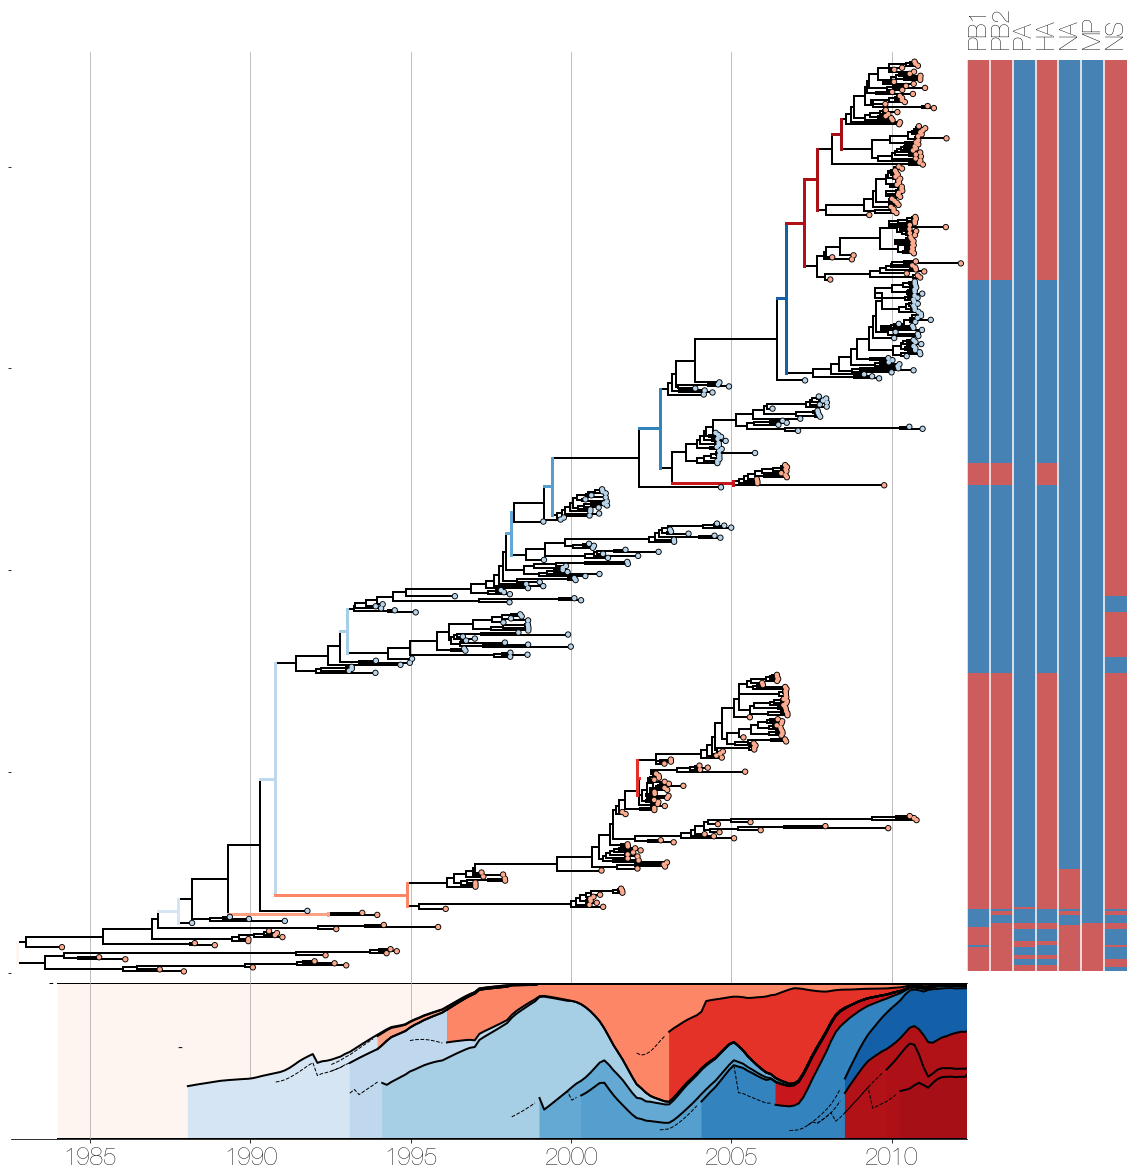

In [24]:
fig = plt.subplots(figsize=(20,20),facecolor='w')

gs = GridSpec(2, 2,height_ratios=[6,1],width_ratios=[6,1],hspace=0.0,wspace=0.0)
ax_tree = plt.subplot(gs[0])
ax_muller = plt.subplot(gs[2],sharex=ax_tree)
ax_genome = plt.subplot(gs[1],sharey=ax_tree)

condition=lambda x:x.branchType=='node' and ((len([1 for k in x.children if k.branchType=='node' and len(k.leaves)>=15])==2) or (x.parent.traits.has_key(traitName) and x.traits[traitName]!=x.parent.traits[traitName]) or x==ll.root)

ll.sortBranches(descending=False)
traitName='PB2'
def plot_subclade(ax, cfreq, clade, pivots):
    """ Iteratively plot clade frequencies.
        Code written by Richard Neher.
    """
    
    if clade.traits.has_key(traitName):
        if clade.traits[traitName]=='V':
            cmap=mpl.cm.Reds
        else:
            cmap=mpl.cm.Blues
    else:
        cmap=mpl.cm.Purples_r
    
    if clade.branchType=='node':
        if condition(clade):
            fr=clade.height/ll.treeHeight
            colour=cmap(fr)
            ec='none'
            cfs=clade.traits['cf']
            inc=cfs
            idx0,idx1=None,None

            idx_cfs=np.where((cfreq+inc)>0.0) ## identify indices where frequencies are >0.0
            idx_pvt=np.where(clade.absoluteTime<pivots) ## identify indices where pivots are greater than date of node 
            idx0=max([min(idx[0]) for idx in [idx_cfs,idx_pvt] if len(idx[0])>0]) ## pick the one that's higher
#             print [bt.decimalDate(ll.tipMap[k].split('_')[-1],variable=True) for k in clade.leaves]
            earliest=min([bt.decimalDate(ll.tipMap[k].split('_')[-1],variable=True) for k in clade.leaves])
            idx_lf=np.where(earliest<pivots) ## identify indices where pivots are greater than date of node 
            idx1=idx_lf[0][0]
            
            i=clade.traits['cf']
            p=pivots
            c=cfreq
            
            I=i[idx0:]
            P=p[idx0:]
            C=c[idx0:]
            
            ax.fill_between(p[idx1:],c[idx1:],c[idx1:]+inc[idx1:],
                        facecolor=colour,
                        edgecolor=ec,alpha=1.0,
                        linestyle='-',zorder=sorted([k.height for k in ll.Objects]).index(clade.height))
            
            ax.plot(p[idx1:],c[idx1:],ls='-',color='k',lw=2,zorder=int(clade.height*100001))
            ax.plot(p[idx1:],c[idx1:]+inc[idx1:],ls='-',color='k',lw=2,zorder=int(clade.height*100001))
            
            ax.plot(p[idx0:idx1],c[idx0:idx1],ls='--',color='k',lw=1,zorder=int(clade.height*100001))
            ax.plot(p[idx0:idx1],c[idx0:idx1]+inc[idx0:idx1],ls='--',color='k',lw=1,zorder=int(clade.height*100001))
            
    tmp_cfreq = np.copy(cfreq)
    
    for child in clade.children:
        if child.branchType=='node':
            tmp_cfreq = plot_subclade(ax, tmp_cfreq, child, pivots)
    
    return cfreq+clade.traits['cf']

cfreq = np.zeros_like(pivots) ## empty list to hold trajectories
plot_subclade(ax_muller, cfreq, ll.root, pivots)

background_tree=lambda k: condition(k)==False
focus_tree=lambda k: condition(k)
x_attr=lambda k: k.absoluteTime
c_func=lambda k: mpl.cm.Reds(k.height/ll.treeHeight) if k.traits[traitName]=='V' else mpl.cm.Blues(k.height/ll.treeHeight)
b_func=lambda k: 3

ll.plotTree(ax_tree,target=background_tree,x_attr=x_attr) ## black regular tree
ll.plotTree(ax_tree,target=focus_tree,x_attr=x_attr,colour_function=c_func,branchWidth=b_func) ## coloured focus tree

c_func=lambda k: mpl.cm.Reds(0.3) if k.traits[traitName]=='V' else mpl.cm.Blues(0.3)
cu_func=lambda k: 'k'
s_func=lambda k: 20
su_func=lambda k: 40
z_func=lambda k: 100
zu_func=lambda k: 99

ll.plotPoints(ax_tree,x_attr=x_attr,size_function=s_func,colour_function=c_func,zorder_function=z_func)
ll.plotPoints(ax_tree,x_attr=x_attr,size_function=su_func,colour_function=cu_func,zorder_function=zu_func)

segments=['PB1','PB2','PA','HA','NA','MP','NS'] ## keys for traits
for k in ll.Objects: ## iterate over branches
    for s in range(len(segments)): ## iterate over trait keys
        c='indianred' if k.traits[segments[s]]=='V' else 'steelblue' ## red for V, blue for Y
        lineage=plt.Rectangle((s,k.y),1,1,facecolor=c,edgecolor='none') ## rectangle with height and width 1, at y position of tip and at the index of the key
        ax_genome.add_patch(lineage) ## add coloured rectangle to plot
ax_genome.set_xticks(np.arange(0.5,len(segments)+0.5))
ax_genome.set_xticklabels(segments,rotation=90)
[ax_genome.axvline(x,color='w') for x in range(len(segments))]
  
ats=[k.absoluteTime for k in ll.Objects]
fr=0.2
ax_muller.set_xlim(min(pivots),max(pivots))
ax_tree.set_xlim(min(ats)-fr,max(ats)+fr)
ax_genome.set_xlim(0,len(segments))

ax_muller.set_ylim(0,1)
# ax_muller.invert_yaxis()
ax_tree.set_ylim(-5,ll.ySpan+5)

[ax_muller.spines[loc].set_visible(False) for loc in ['top','right','left']] ## no axes
[ax_tree.spines[loc].set_visible(False) for loc in ['top','right','left']] ## no axes
[ax_genome.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax_tree.tick_params(axis='x',size=0) ## no labels
ax_muller.tick_params(axis='y',size=0)
ax_muller.tick_params(axis='x',labelsize=24)
ax_genome.tick_params(size=0,labelsize=24)
ax_muller.set_yticklabels([])
ax_tree.set_yticklabels([])
ax_genome.xaxis.set_ticks_position('top')

ax_muller.grid(axis='x')
ax_tree.grid(axis='x')
plt.show()